In [ ]:
import pandas as pd
# sys.path.insert(0, 'D:\GitHub Repos\MLib in Python\MLib-in-python')
# import MLib
import warnings
warnings.filterwarnings("ignore")
import sklearn

In [ ]:
DFOriginal = pd.read_csv('csv-wsn-ids-ds.csv')
OutPutLabel : str = 'Attack type'
InputLabels : list = DFOriginal.columns.tolist()
InputLabels.remove(OutPutLabel)
print('Input Labels Count: ', len(InputLabels))
InputLabels

In [ ]:
DFOriginal[OutPutLabel].value_counts().index.tolist()

In [ ]:
DFOriginal.dtypes

In [ ]:
DFOriginal.info()

In [ ]:
# Display the number of missing values in each column
DFOriginal.isnull().sum()

In [ ]:
DFOriginal.describe()

In [ ]:
# Display the number of unique values in each column
DFOriginal.nunique()

In [ ]:
DFOriginal.drop_duplicates(inplace=True)

In [ ]:
DFOriginal.info()

In [ ]:
DFOriginal.hist(figsize=(20, 15), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
DFOriginal[OutPutLabel].value_counts()

In [ ]:
# Display the first few rows of the dataset
DFOriginal.head()

In [ ]:
DFOriginalInputs = DFOriginal[InputLabels]
DFOriginalOutput = DFOriginal[OutPutLabel]

In [ ]:
# print th correlation matrix with colored cells
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(DFOriginalInputs.corr(), annot=True, fmt=".1f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()


In [ ]:
DFOriginalOutput.value_counts().plot(kind='bar')
plt.title('Class Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
def ResampleDFIO(DFinput : pd.DataFrame, DFoutput : pd.DataFrame) -> pd.DataFrame:
    smote = SMOTE()
    DFSampledinput, DFSampledoutput = smote.fit_resample(DFinput, DFoutput)
    # merge thsamplede  inputs and outputs back into a single DataFrame
    DFSampled = pd.concat([DFSampledinput, DFSampledoutput], axis=1)
    return DFSampled

In [ ]:
def LabelEncoding(DF : pd.DataFrame) -> pd.DataFrame:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    encoded = le.fit_transform(DF)
    return pd.DataFrame(encoded, columns=DF.columns)

In [ ]:
def OneHotEncoding(DF : pd.DataFrame) -> pd.DataFrame:
    from sklearn.preprocessing import OneHotEncoder
    categorical_columns = DF.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    encoded = ohe.fit_transform(DF[categorical_columns])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorical_columns))
    DFONE = pd.concat([DF.drop(columns=categorical_columns), encoded_df], axis=1)
    return DFONE


In [ ]:
DFOriginalInputs.shape, DFOriginalOutput.shape

In [ ]:
DFOriginalOutput = pd.DataFrame(DFOriginalOutput)
DFLEOutput = LabelEncoding(DFOriginalOutput)
DFLEOutput.head()

In [ ]:
DFLEOutput.value_counts().sort_index().plot(kind='bar')

In [ ]:
DFOHEOutput = OneHotEncoding(DFOriginalOutput)
DFOHEOutput.head()
DFInputOHEOutput = pd.concat([DFOriginal.drop(columns=OutPutLabel), DFOHEOutput], axis=1)

In [ ]:
DFInputOHEOutput.head()

In [ ]:
CorrelationMatrixInputOHEOutput = DFInputOHEOutput.corr()

In [ ]:
CorrelationMatrixInputOHEOutput = CorrelationMatrixInputOHEOutput.round(2)
plt.subplots(figsize=(15,15))
sns.heatmap(CorrelationMatrixInputOHEOutput, cmap='Reds', annot=True)

In [ ]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
TrainInput, TestInput, TrainOutput, TestOutput = train_test_split(DFOriginalInputs, DFLEOutput, train_size=0.8, random_state=42, stratify=DFLEOutput)

In [ ]:
# TODO: use other scaling methods, like standardscaler, robustscaler

mms = sklearn.preprocessing.MinMaxScaler()
DFTrainInputScaled = pd.DataFrame(mms.fit_transform(TrainInput), columns=TrainInput.columns)
DFTestInputScaled = pd.DataFrame(mms.transform(TestInput), columns=TestInput.columns)

In [ ]:
DFTrainInputScaled

In [ ]:
# DFSampledOutput.value_counts().plot(kind='bar')
# plt.title('Class Distribution of Attack Types')
# plt.xlabel('Attack Type')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# DFSampledOutput.value_counts()  

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# import pandas as pd

# import matplotlib.pyplot as plt

# # Train a Random Forest Classifier
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(DFTrainInputs, DFTrainOutput)

# # Get feature importances
# feature_importances = pd.Series(rf.feature_importances_, index=DFTrainInputs.columns)

# # Sort features by importance
# sorted_features = feature_importances.sort_values(ascending=False)

# # Plot feature importances
# plt.figure(figsize=(12, 6))
# sorted_features.plot(kind='bar')
# plt.title('Feature Importances')
# plt.xlabel('Features')
# plt.ylabel('Importance Score')
# plt.show()

# top_features = sorted_features.head(12).index.tolist()
# print("Top 12 Features:", top_features)
top_features = [' ADV_S', ' SCH_S', 'Expaned Energy', ' Is_CH', ' Data_Sent_To_BS', ' dist_CH_To_BS', ' ADV_R', ' DATA_R', ' JOIN_R', ' DATA_S', 'Rank', ' Time']

In [ ]:
DFTrainInputScaledSelected = DFTrainInputScaled[top_features]
DFTestInputScaledSelected = DFTestInputScaled[top_features]

## 1- Logistic Regression

In [ ]:
import sklearn.linear_model
# make a random search for the best hyperparameters of the logistic regression model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'C': uniform(0.1, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': randint(100, 1000)
}

# ModelLR = sklearn.linear_model.LogisticRegression(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelLR, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)

# ModelLR = sklearn.linear_model.LogisticRegression(**best_params, class_weight='balanced')
# ModelLR.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

ModelLR = sklearn.linear_model.LogisticRegression(max_iter=1000,solver='newton-cg',class_weight='balanced')
ModelLR.fit(DFTrainInputScaledSelected, TrainOutput)

In [ ]:
ypred = ModelLR.predict(DFTestInputScaledSelected)
ypredProba = ModelLR.predict_proba(DFTestInputScaledSelected)

In [ ]:
TestOutput.shape, ypred.shape

In [ ]:
ConfusionMatrixLR = sklearn.metrics.confusion_matrix(TestOutput, ypred)
print("Confusion Matrix:\n", ConfusionMatrixLR)

In [ ]:
LogLossLR = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossLR)

In [ ]:
accuracyLR = sklearn.metrics.accuracy_score(TestOutput,ypred)
balanced_accuracyLR = sklearn.metrics.balanced_accuracy_score(TestOutput,ypred)
precisionLR = sklearn.metrics.precision_score(TestOutput,ypred,average='weighted')
recallLR = sklearn.metrics.recall_score(TestOutput,ypred,average='weighted')
f1LR = sklearn.metrics.f1_score(TestOutput,ypred,average='weighted')
roc_aucLR = sklearn.metrics.roc_auc_score(TestOutput,ypredProba, average='weighted', multi_class='ovr')
matthews_corrcoefLR = sklearn.metrics.matthews_corrcoef(TestOutput,ypred)

In [ ]:
print(f'{'accuracy': <30}', accuracyLR)
print(f'{'balanced_accuracy': <30}', balanced_accuracyLR)
print(f'{'precision': <30}', precisionLR)
print(f'{'recall': <30}', recallLR)
print(f'{'f1': <30}', f1LR)
print(f'{'roc_auc': <30}', roc_aucLR)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefLR)

In [ ]:
import sklearn.metrics


plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixLR.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 2- Decision Tree

In [ ]:
import sklearn.tree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
}
# ModelDT = sklearn.tree.DecisionTreeClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelDT, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelDT = sklearn.tree.DecisionTreeClassifier(**best_params, class_weight='balanced')
# ModelDT.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

ModelDT = sklearn.tree.DecisionTreeClassifier(class_weight='balanced')

In [ ]:
ModelDT.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

In [ ]:
ypred = ModelDT.predict(DFTestInputScaledSelected)
ypredProba = ModelDT.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixDT = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixDT

In [ ]:
import sklearn.metrics

accuracyDT = sklearn.metrics.accuracy_score(TestOutput,ypred)
balanced_accuracyDT = sklearn.metrics.balanced_accuracy_score(TestOutput, ypred)
precisionDT = sklearn.metrics.precision_score(TestOutput, ypred, average='weighted')
recallDT = sklearn.metrics.recall_score(TestOutput, ypred, average='weighted')
f1DT = sklearn.metrics.f1_score(TestOutput, ypred, average='weighted')
roc_aucDT = sklearn.metrics.roc_auc_score(TestOutput, ypredProba, average='weighted', multi_class='ovr')
matthews_corrcoefDT = sklearn.metrics.matthews_corrcoef(TestOutput,ypred)

In [ ]:
print(f'{'accuracy': <30}', accuracyDT)
print(f'{'balanced_accuracy': <30}', balanced_accuracyDT)
print(f'{'precision': <30}', precisionDT)
print(f'{'recall': <30}', recallDT)
print(f'{'f1': <30}', f1DT)
print(f'{'roc_auc': <30}', roc_aucDT)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefDT)

In [ ]:
LogLossLR = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossLR)

In [ ]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixDT.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 3- Random Forest

In [702]:
# make a random search for the best hyperparameters of the random forest model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_estimators': randint(10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
}
# ModelRF = sklearn.ensemble.RandomForestClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelRF, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelRF = sklearn.ensemble.RandomForestClassifier(**best_params, class_weight='balanced')
# ModelRF.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

ModelRF = sklearn.ensemble.RandomForestClassifier(class_weight='balanced')

In [703]:
ModelRF.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
ypred = ModelRF.predict(DFTestInputScaledSelected)
ypredProba = ModelRF.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixRF = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixRF

array([[ 1996,     0,    14,     0,     0],
       [    0,   625,     0,     6,     0],
       [   24,     0,  2739,    19,     0],
       [    2,    46,    16, 66336,     8],
       [    1,     0,     3,   100,  1223]])

In [704]:
import sklearn.metrics

accuracyRF = sklearn.metrics.accuracy_score(TestOutput,ypred)
balanced_accuracyRF = sklearn.metrics.balanced_accuracy_score(TestOutput, ypred)
precisionRF = sklearn.metrics.precision_score(TestOutput, ypred, average='weighted')
recallRF = sklearn.metrics.recall_score(TestOutput, ypred, average='weighted')
f1RF = sklearn.metrics.f1_score(TestOutput, ypred, average='weighted')
roc_aucRF = sklearn.metrics.roc_auc_score(TestOutput, ypredProba, average='weighted', multi_class='ovr')
matthews_corrcoefRF = sklearn.metrics.matthews_corrcoef(TestOutput,ypred)

In [ ]:
print(f'{'accuracy': <30}', accuracyRF)
print(f'{'balanced_accuracy': <30}', balanced_accuracyRF)
print(f'{'precision': <30}', precisionRF)
print(f'{'recall': <30}', recallRF)
print(f'{'f1': <30}', f1RF)
print(f'{'roc_auc': <30}', roc_aucRF)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefRF)

accuracy                       0.996733098225758
balanced_accuracy              0.9777226256880509
precision                      0.9967641602071206
recall                         0.996733098225758
f1                             0.9967157943147299
roc_auc                        0.9953192094623712
matthews_corrcoef              0.9811058407332409


In [706]:
LogLossRF = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossRF)

Log Loss:  0.0380896149827677


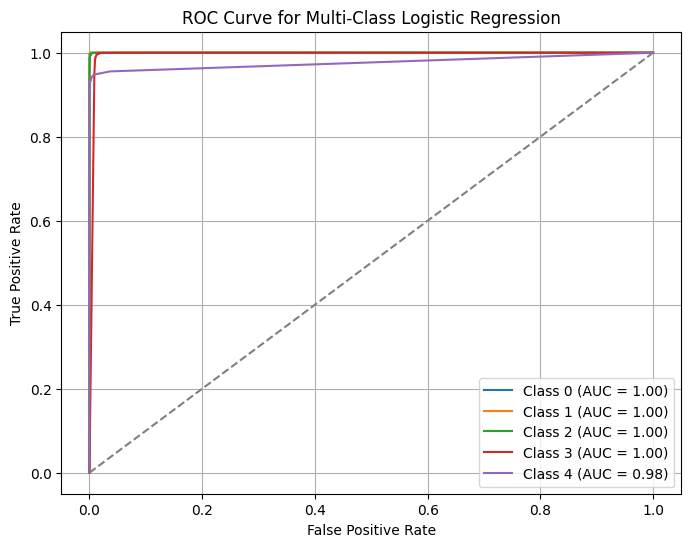

In [707]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixRF.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 4- SVM

In [709]:
import sklearn.svm
# make a random search for the best hyperparameters of the SVM model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(1, 5),
    'gamma': ['scale', 'auto'],
    'coef0': uniform(0, 1),
    'shrinking': [True, False],
}
# ModelSVM = sklearn.svm.SVC(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelSVM, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelSVM = sklearn.svm.SVC(**best_params, class_weight='balanced')
# ModelSVM.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

ModelSVM = sklearn.svm.LinearSVC()

In [710]:
ModelSVM.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

LinearSVC()

In [713]:
ypred = ModelSVM.predict(DFTestInputScaledSelected)
ypredProba = ModelSVM._predict_proba_lr(DFTestInputScaledSelected)
ConfusionMatrixSVM = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixSVM

array([[ 2007,     0,     2,     1,     0],
       [    0,   585,     9,    37,     0],
       [ 1080,     0,  1120,   582,     0],
       [    2,    64,   392, 65945,     5],
       [    5,     0,     1,   178,  1143]])

In [714]:
import sklearn.metrics

accuracySVM = sklearn.metrics.accuracy_score(TestOutput,ypred)
balanced_accuracySVM = sklearn.metrics.balanced_accuracy_score(TestOutput, ypred)
precisionSVM = sklearn.metrics.precision_score(TestOutput, ypred, average='weighted')
recallSVM = sklearn.metrics.recall_score(TestOutput, ypred, average='weighted')
f1SVM = sklearn.metrics.f1_score(TestOutput, ypred, average='weighted')
roc_aucSVM = sklearn.metrics.roc_auc_score(TestOutput, ypredProba, average='weighted', multi_class='ovr')
matthews_corrcoefSVM = sklearn.metrics.matthews_corrcoef(TestOutput,ypred)

In [715]:
print(f'{'accuracy': <30}', accuracySVM)
print(f'{'balanced_accuracy': <30}', balanced_accuracySVM)
print(f'{'precision': <30}', precisionSVM)
print(f'{'recall': <30}', recallSVM)
print(f'{'f1': <30}', f1SVM)
print(f'{'roc_auc': <30}', roc_aucSVM)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefSVM)

accuracy                       0.9677683917001558
balanced_accuracy              0.8365129380604144
precision                      0.9684839891605835
recall                         0.9677683917001558
f1                             0.965164194912079
roc_auc                        0.9903742683649519
matthews_corrcoef              0.8114356882581528


In [716]:
LogLossSVM = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossSVM)

Log Loss:  0.38605755132562164


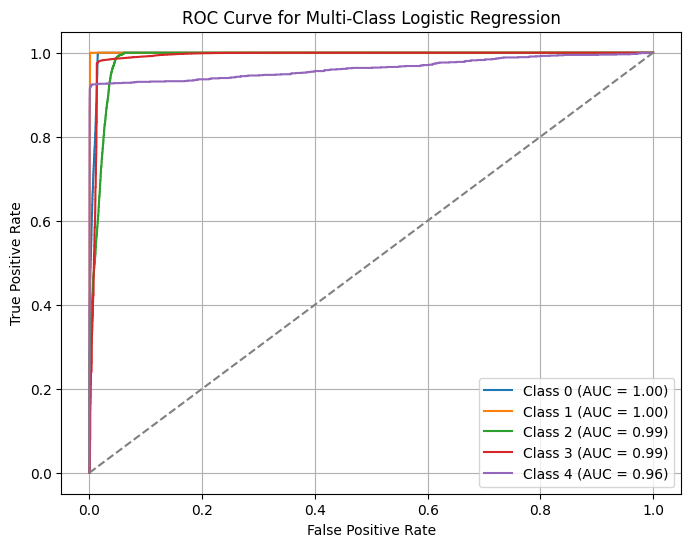

In [717]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixSVM.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 5- KNN

In [720]:
# knn
import sklearn.neighbors
# make a random search for the best hyperparameters of the knn model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': randint(1, 50),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}
# ModelKNN = sklearn.neighbors.KNeighborsClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelKNN, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelKNN = sklearn.neighbors.KNeighborsClassifier(**best_params, class_weight='balanced')
# ModelKNN.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
ModelKNN = sklearn.neighbors.KNeighborsClassifier(n_neighbors=7)


In [721]:
ModelKNN.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

KNeighborsClassifier(n_neighbors=7)

In [722]:
ypred = ModelKNN.predict(DFTestInputScaledSelected)
ypredProba = ModelKNN.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixKNN = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixKNN


array([[ 1954,     0,    53,     0,     3],
       [    0,   587,     2,    42,     0],
       [   91,     0,  2645,    46,     0],
       [    2,    55,    59, 66284,     8],
       [    4,     0,     9,   112,  1202]])

In [723]:
import sklearn.metrics

accuracyKNN = sklearn.metrics.accuracy_score(TestOutput,ypred)
balanced_accuracyKNN = sklearn.metrics.balanced_accuracy_score(TestOutput, ypred)
precisionKNN = sklearn.metrics.precision_score(TestOutput, ypred, average='weighted')
recallKNN = sklearn.metrics.recall_score(TestOutput, ypred, average='weighted')
f1KNN = sklearn.metrics.f1_score(TestOutput, ypred, average='weighted')
roc_aucKNN = sklearn.metrics.roc_auc_score(TestOutput, ypredProba, average='weighted', multi_class='ovr')
matthews_corrcoefKNN = sklearn.metrics.matthews_corrcoef(TestOutput,ypred)

In [724]:
print(f'{'accuracy': <30}', accuracyKNN)
print(f'{'balanced_accuracy': <30}', balanced_accuracyKNN)
print(f'{'precision': <30}', precisionKNN)
print(f'{'recall': <30}', recallKNN)
print(f'{'f1': <30}', f1KNN)
print(f'{'roc_auc': <30}', roc_aucKNN)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefKNN)

accuracy                       0.9933568440908718
balanced_accuracy              0.9514197773991631
precision                      0.9933767207665107
recall                         0.9933568440908718
f1                             0.9933283144251266
roc_auc                        0.9928490978883223
matthews_corrcoef              0.961511523855091


In [725]:
LogLossKNN = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossKNN)

Log Loss:  0.08019529041811178


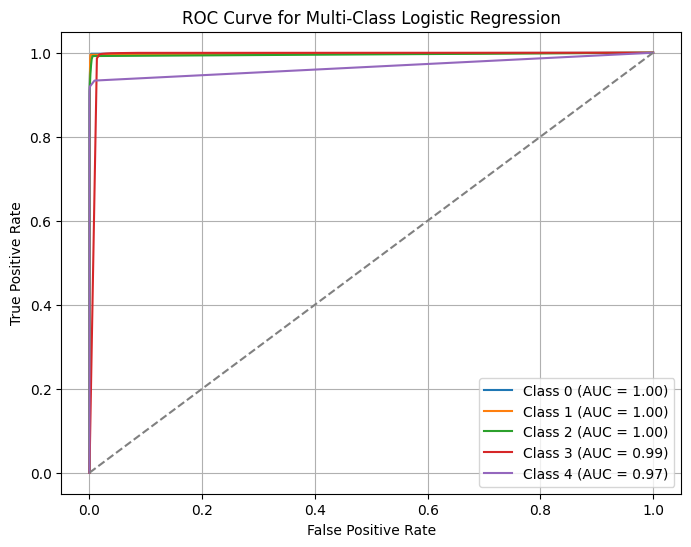

In [726]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixKNN.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 6- XGBClassifier

In [732]:
# XGBClassifier

import xgboost as xgb
# make a random search for the best hyperparameters of the xgboost model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
}
# ModelXGB = xgb.XGBClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelXGB, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelXGB = xgb.XGBClassifier(**best_params, class_weight='balanced')
# ModelXGB.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
ModelXGB = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', class_weight='balanced')


In [733]:
ModelXGB.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [734]:
ypred = ModelXGB.predict(DFTestInputScaledSelected)
ypredProba = ModelXGB.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixXGB = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixXGB


array([[ 2000,     0,    10,     0,     0],
       [    0,   610,     0,    21,     0],
       [   25,     0,  2736,    21,     0],
       [    2,    36,    19, 66343,     8],
       [    1,     0,     1,   104,  1221]])

In [735]:
import sklearn.metrics

accuracyXGB = sklearn.metrics.accuracy_score(TestOutput,ypred)
balanced_accuracyXGB = sklearn.metrics.balanced_accuracy_score(TestOutput, ypred)
precisionXGB = sklearn.metrics.precision_score(TestOutput, ypred, average='weighted')
recallXGB = sklearn.metrics.recall_score(TestOutput, ypred, average='weighted')
f1XGB = sklearn.metrics.f1_score(TestOutput, ypred, average='weighted')
roc_aucXGB = sklearn.metrics.roc_auc_score(TestOutput, ypredProba, average='weighted', multi_class='ovr')
matthews_corrcoefXGB = sklearn.metrics.matthews_corrcoef(TestOutput,ypred)

In [736]:
print(f'{'accuracy': <30}', accuracyXGB)
print(f'{'balanced_accuracy': <30}', balanced_accuracyXGB)
print(f'{'precision': <30}', precisionXGB)
print(f'{'recall': <30}', recallXGB)
print(f'{'f1': <30}', f1XGB)
print(f'{'roc_auc': <30}', roc_aucXGB)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefXGB)

accuracy                       0.9966100768200333
balanced_accuracy              0.9728702552946812
precision                      0.996616239443846
recall                         0.9966100768200333
f1                             0.9965853185025607
roc_auc                        0.9981819377791441
matthews_corrcoef              0.9803656540787812


In [737]:
LogLossXGB = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossXGB)

Log Loss:  0.013041641801999963


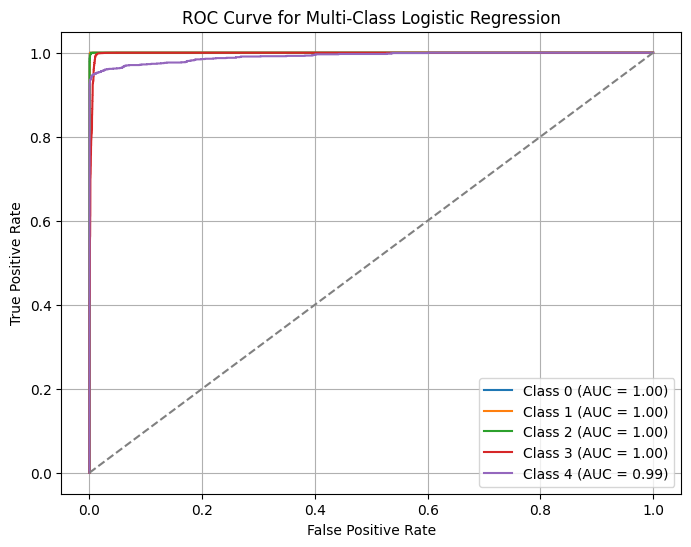

In [738]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixXGB.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## other

In [ ]:
"""
TODO: 
    - run the random search for all the models and use the best hyperparameters for each model
        - LGBMClassifier
        - ExtraTreesClassifier
        - BaggingClassifier
        - VotingClassifier
"""

'\nTODO: \n    - run the random search for all the models and use the best hyperparameters for each model\n        - XGBClassifier\n        - LGBMClassifier\n        - ExtraTreesClassifier\n        - BaggingClassifier\n        - VotingClassifier\n'